In this notebook we train:
- EfficientNetB2, classifier only
- EfficientNetB2, whole network

**Dataset**: pre-processed, without class-weights

### Environment

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import random
from PIL import Image
import warnings
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import filters
from skimage.color import rgb2gray
from tensorflow.keras.optimizers import Adam

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

warnings.filterwarnings('ignore')

2.6.4


In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

### Dataset

In [ ]:
data_dir = '/kaggle/input/corino-preprocessed'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

h = 256
w = 256

#imageDataGenerator
train_set = ImageDataGenerator().flow_from_directory(directory = training_dir,
                                                     target_size = (h, w),
                                                     color_mode = 'rgb',
                                                     classes = None,
                                                     class_mode = 'categorical',
                                                     batch_size = 32, 
                                                     shuffle = True,
                                                     seed = seed)

validation_set = ImageDataGenerator().flow_from_directory(directory = validation_dir,
                                                     target_size = (h, w),
                                                     color_mode = 'rgb',
                                                     classes = None,
                                                     class_mode = 'categorical',
                                                     batch_size = 32, 
                                                     shuffle = False,
                                                     seed = seed)

test_set = ImageDataGenerator().flow_from_directory(directory = test_dir,
                                                     target_size = (h, w),
                                                     color_mode = 'rgb',
                                                     classes = None,
                                                     class_mode = 'categorical',
                                                     batch_size = 32, 
                                                     shuffle = False,
                                                     seed = seed)

Found 10834 images belonging to 3 classes.
Found 2327 images belonging to 3 classes.
Found 2309 images belonging to 3 classes.


### Transfer Learning

In [ ]:
input_shape = (256, 256, 3)

In [ ]:
import keras.backend as K
def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
#Download net
supernet = tf.keras.applications.efficientnet.EfficientNetB2(
    include_top=False,
    weights='imagenet',
    input_shape=(input_shape)
)

#supernet.summary()
#tfk.utils.plot_model(supernet)

2023-02-01 10:51:40.038042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 10:51:40.039012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 10:51:40.122985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 10:51:40.123827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 10:51:40.124597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

31801344/31790344 [==============================] - 0s 0us/step


In [ ]:
#Classifier
supernet.trainable = False

inputs = tfk.Input(shape=input_shape)
x = supernet(inputs) #one layer is supernet
x = tfkl.GlobalAveragePooling2D(name = 'gap')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    512, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    128, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    3, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                 optimizer=tfk.optimizers.Adam(1e-3),
                 metrics=['accuracy',
                          tf.keras.metrics.Recall(name='recall'),
                          tf.keras.metrics.Precision(name='precision'),
                          f1])
tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 8, 8, 1408)        7768569   
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               721408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664 

In [ ]:
# Train the model
history = tl_model.fit(
    x = train_set,
    epochs = 200,
    validation_data = validation_set,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_f1', patience=10, restore_best_weights=True, mode='max'),
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1', patience=5, factor=0.1, verbose=1, mode='max')]
).history

2023-02-01 10:51:47.113932: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-02-01 10:51:56.503883: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


339/339 [==============================] - 136s 356ms/step - loss: 0.4519 - accuracy: 0.8171 - recall: 0.8022 - precision: 0.8294 - f1: 0.8146 - val_loss: 0.2773 - val_accuracy: 0.8930 - val_recall: 0.8831 - val_precision: 0.9017 - val_f1: 0.8902
Epoch 2/200
339/339 [==============================] - 51s 149ms/step - loss: 0.3288 - accuracy: 0.8664 - recall: 0.8608 - precision: 0.8715 - f1: 0.8661 - val_loss: 0.2390 - val_accuracy: 0.9080 - val_recall: 0.9042 - val_precision: 0.9120 - val_f1: 0.9064
Epoch 3/200
339/339 [==============================] - 50s 148ms/step - loss: 0.2979 - accuracy: 0.8809 - recall: 0.8770 - precision: 0.8860 - f1: 0.8815 - val_loss: 0.2401 - val_accuracy: 0.9093 - val_recall: 0.9046 - val_precision: 0.9144 - val_f1: 0.9084
Epoch 4/200
339/339 [==============================] - 50s 149ms/step - loss: 0.2709 - accuracy: 0.8911 - recall: 0.8864 - precision: 0.8939 - f1: 0.8901 - val_loss: 0.2145 - val_accuracy: 0.9209 - val_recall: 0.9171 - val_precision: 0.9

### Transfer Learning: results

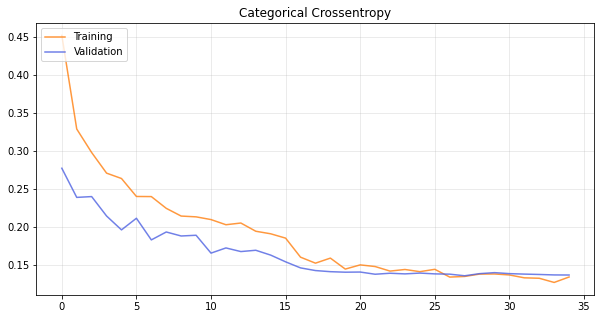

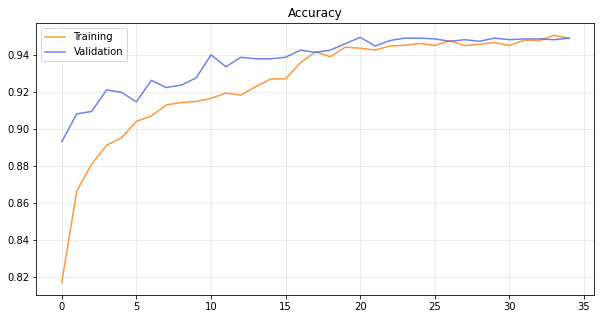

In [ ]:
# Plot the training

# loss
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)


In [ ]:
tl_model.save('/kaggle/working')

2023-02-01 11:28:27.241303: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [ ]:
!zip -r efficientnetb2.zip /kaggle/working
from IPython.display import FileLink 
FileLink(r'efficientnetb2.zip')

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/variables/ (stored 0%)
  adding: kaggle/working/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/variables/variables.index (deflated 74%)
  adding: kaggle/working/assets/ (stored 0%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)
  adding: kaggle/working/keras_metadata.pb (deflated 96%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/saved_model.pb (deflated 91%)


/kaggle/working/efficientnetb2.zip

##### Validation

In [ ]:
#cf on validation for comparisons
val_predictions = tl_model.predict(validation_set)

In [ ]:
tl_model.evaluate(validation_set)

73/73 [==============================] - 9s 121ms/step - loss: 0.1396 - accuracy: 0.9489 - recall: 0.9489 - precision: 0.9497 - f1: 0.9486


[0.13956265151500702,
 0.9488611817359924,
 0.9488611817359924,
 0.9496774077415466,
 0.9485672116279602]

In [ ]:
val_predictions = tl_model.predict(validation_set)
y_val = validation_set.labels

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def print_evaluation(y_true, predictions):
    cm = confusion_matrix(y_true, predictions, normalize='pred')
    cm_display = ConfusionMatrixDisplay(cm, display_labels = ['N', 'P', 'T'])
    cm_display.plot()
    
    print(classification_report(y_true, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9541    0.9662    0.9601      1420
           1     0.9569    0.9780    0.9673       635
           2     0.8958    0.7904    0.8398       272

    accuracy                         0.9489      2327
   macro avg     0.9356    0.9115    0.9224      2327
weighted avg     0.9480    0.9489    0.9480      2327



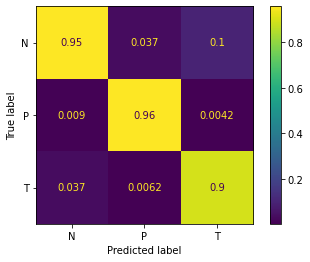

In [ ]:
print_evaluation(y_val, np.argmax(val_predictions, axis=-1))

##### Test

In [ ]:
tl_model.evaluate(test_set)

73/73 [==============================] - 23s 313ms/step - loss: 0.1603 - accuracy: 0.9376 - recall: 0.9372 - precision: 0.9380 - f1: 0.9360


[0.16028062999248505,
 0.9376353621482849,
 0.9372022747993469,
 0.9380147457122803,
 0.9360241889953613]

In [ ]:
val_predictions = tl_model.predict(test_set)
y_val = test_set.labels

              precision    recall  f1-score   support

           0     0.9439    0.9547    0.9493      1392
           1     0.9433    0.9700    0.9565       634
           2     0.8876    0.7809    0.8308       283

    accuracy                         0.9376      2309
   macro avg     0.9249    0.9019    0.9122      2309
weighted avg     0.9368    0.9376    0.9367      2309



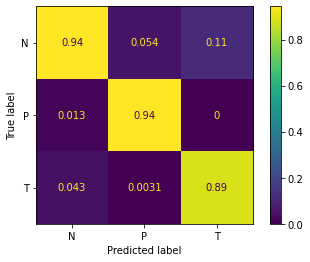

In [ ]:
print_evaluation(y_val, np.argmax(val_predictions, axis=-1))

### Fine Tuning

In [ ]:
# Set all VGG16 layers to True
tl_model .get_layer('efficientnetb2').trainable = True
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('efficientnetb2').layers):
  layer.trainable = True
for i, layer in enumerate(tl_model.get_layer('efficientnetb2').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block1b_dwconv True
18 block1b_bn True
19 block1b_activation True
20 block1b_se_squeeze True
21 block1b_se_reshape True
22 block1b_se_reduce True
23 block1b_se_expand True
24 block1b_se_excite True
25 block1b_project_conv True
26 block1b_project_bn True
27 block1b_drop True
28 block1b_add True
29 block2a_expand_conv True
30 block2a_expand_bn True
31 block2a_expand_activation True
32 block2a_dwconv_pad True
33 block2a_dwconv True
34 block2a_bn True
35 block2a_activation True
36 block2a_se_squeeze True
37 block2a_se_reshape True
38 block2a_se_reduce True
39 block2a_se_expand True
40 block2a_se_excite True
41 

In [ ]:
finetuned_model = tl_model
finetuned_model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                 optimizer=tfk.optimizers.Adam(1e-3),
                 metrics=['accuracy',
                          tf.keras.metrics.Recall(name='recall'),
                          tf.keras.metrics.Precision(name='precision'),
                          f1])
finetuned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 8, 8, 1408)        7768569   
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               721408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664 

In [ ]:
# Train the model
history = finetuned_model.fit(
    x = train_set,
    epochs = 100,
    validation_data = validation_set,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_f1', patience=10, restore_best_weights=True, mode='max'),
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1', patience=5, factor=0.1, verbose=1, mode='max')]
).history

Epoch 1/100
339/339 [==============================] - 239s 630ms/step - loss: 0.2806 - accuracy: 0.8985 - recall: 0.8945 - precision: 0.9030 - f1: 0.8987 - val_loss: 0.2278 - val_accuracy: 0.9347 - val_recall: 0.9330 - val_precision: 0.9370 - val_f1: 0.9330
Epoch 2/100
339/339 [==============================] - 212s 624ms/step - loss: 0.1693 - accuracy: 0.9387 - recall: 0.9371 - precision: 0.9407 - f1: 0.9388 - val_loss: 0.1774 - val_accuracy: 0.9351 - val_recall: 0.9338 - val_precision: 0.9362 - val_f1: 0.9332
Epoch 3/100
339/339 [==============================] - 212s 624ms/step - loss: 0.1210 - accuracy: 0.9587 - recall: 0.9571 - precision: 0.9603 - f1: 0.9585 - val_loss: 0.1229 - val_accuracy: 0.9557 - val_recall: 0.9553 - val_precision: 0.9557 - val_f1: 0.9549
Epoch 4/100
339/339 [==============================] - 211s 621ms/step - loss: 0.0992 - accuracy: 0.9669 - recall: 0.9653 - precision: 0.9681 - f1: 0.9666 - val_loss: 0.1295 - val_accuracy: 0.9609 - val_recall: 0.9587 - val

In [ ]:
finetuned_model.save('/kaggle/working/finetuning')

In [ ]:
!zip -r efficientnetb2_FT.zip /kaggle/working/finetuning
from IPython.display import FileLink 
FileLink(r'efficientnetb2_FT.zip')

  adding: kaggle/working/finetuning/ (stored 0%)
  adding: kaggle/working/finetuning/variables/ (stored 0%)
  adding: kaggle/working/finetuning/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/finetuning/variables/variables.index (deflated 78%)
  adding: kaggle/working/finetuning/assets/ (stored 0%)
  adding: kaggle/working/finetuning/keras_metadata.pb (deflated 96%)
  adding: kaggle/working/finetuning/saved_model.pb (deflated 91%)


/kaggle/working/efficientnetb2_FT.zip

### Fine Tuning: results

##### Validation

In [ ]:
finetuned_model.evaluate(validation_set)

73/73 [==============================] - 9s 121ms/step - loss: 0.1430 - accuracy: 0.9768 - recall: 0.9764 - precision: 0.9772 - f1: 0.9767


[0.14296555519104004,
 0.9767941832542419,
 0.9763644337654114,
 0.9772043228149414,
 0.9766887426376343]

In [ ]:
val_predictions = finetuned_model.predict(validation_set)
y_val = validation_set.labels

              precision    recall  f1-score   support

           0     0.9804    0.9845    0.9824      1420
           1     0.9781    0.9843    0.9812       635
           2     0.9542    0.9191    0.9363       272

    accuracy                         0.9768      2327
   macro avg     0.9709    0.9626    0.9666      2327
weighted avg     0.9767    0.9768    0.9767      2327



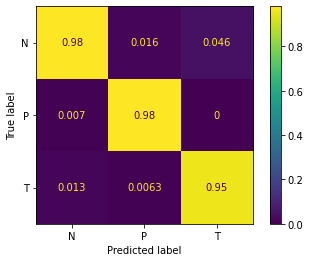

In [ ]:
print_evaluation(y_val, np.argmax(val_predictions, axis=-1))

##### Test

In [ ]:
finetuned_model.evaluate(test_set)

73/73 [==============================] - 9s 120ms/step - loss: 0.1965 - accuracy: 0.9693 - recall: 0.9693 - precision: 0.9697 - f1: 0.9698


[0.19645550847053528,
 0.9692507386207581,
 0.9692507386207581,
 0.9696707129478455,
 0.9698031544685364]

In [ ]:
val_predictions = finetuned_model.predict(test_set)
y_val = test_set.labels

              precision    recall  f1-score   support

           0     0.9695    0.9806    0.9750      1392
           1     0.9734    0.9811    0.9772       634
           2     0.9580    0.8869    0.9211       283

    accuracy                         0.9693      2309
   macro avg     0.9670    0.9495    0.9578      2309
weighted avg     0.9691    0.9693    0.9690      2309



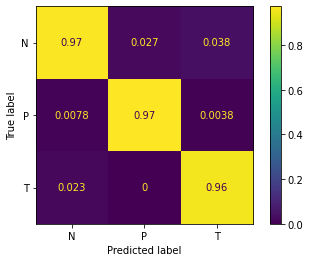

In [ ]:
print_evaluation(y_val, np.argmax(val_predictions, axis=-1))